# LSTM implementation

---

This notebook implements a LSTM model to predict a vector of outputs (Y) given an history of inputs (X).
Using the generator by Chollet where (`lookback`,`num_features`) -> (`targets`)

## 1. Initialisation

In [2]:
# reset variables
%reset -f

# import external modules
import sys, os
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc 
from datetime import datetime
from tabulate import tabulate
from decimal import Decimal

import keras
print("keras.__version__ =", keras.__version__ )
from keras import layers, regularizers, Input, Model
from keras.optimizers import RMSprop, Adam, Nadam
from keras.initializers import RandomUniform
from keras.models import Sequential
from keras import backend as K

import tensorflow as tf
tf.set_random_seed(100)
print("tf.__version__ =", tf.__version__)
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from functions import MAE, RMSE, split_dataset

keras.__version__ = 2.2.4
tf.__version__ = 1.12.0


In [3]:
# Set global paths
ROOT_PATH = os.path.abspath(".").split("src")[0]

# configure matplotlib params and plotting
sns.set()
sns.set_context('paper')
sns.set_style('whitegrid', {'axes.grid': True, 'grid.linestyle': '--'})

rc('figure', figsize=(12,6))
rc('xtick', labelsize=12)
rc('ytick', labelsize=12)
rc('axes', labelsize=13, titlesize=14)
rc('legend', fontsize=14, handlelength=2)
rc('font', family='serif')

SEED=100
np.random.seed(SEED)

## 2. Data loading
<hr> 
Load data from pre-stored files

In [13]:
path = ROOT_PATH + "data/dataframes/"
df_train = pd.read_pickle(path + "df_scaled_train.pkl")
df_valid = pd.read_pickle(path + "df_scaled_valid.pkl")
df_test = pd.read_pickle(path + "df_scaled_test.pkl")

USE_DUMMY_DATA = True
if USE_DUMMY_DATA: 
    num_obs = 10000  # 5000, 10000 or 25000
    path = ROOT_PATH + "data/dummy/"
    df_train = pd.read_pickle(path + "dummy_train_{0}.pkl".format(num_obs))
    df_valid = pd.read_pickle(path + "dummy_valid_{0}.pkl".format(num_obs))
    df_test = pd.read_pickle(path + "dummy_test_{0}.pkl".format(num_obs))

# splitting into training, testing and validation sets
x_train, y_train = split_dataset(df_train.values, delay=1)
x_valid, y_valid = split_dataset(df_valid.values, delay=1)
x_test, y_test = split_dataset(df_test.values, delay=1)

# reading metadata
path = ROOT_PATH + "data/metadata/"

# stats for scaling
stats = pd.read_csv(path+"stats.csv", sep=",")

# tags
headers = df_train.columns.values
target_tags = headers[:3]
feature_tags = headers[3:]

print(df_train.shape, df_valid.shape, df_test.shape)
print(x_train.shape, y_train.shape)

(6000, 21) (2000, 21) (2000, 21)
(5999, 18) (5999, 3)


## 3. Defining a Generator
<hr>
Define a generator to generate batches of data such that the models don't have to read everything at once. 

### Definition

In [14]:
def generator(x_data, y_data, lookback=100, delay=0, min_index=0, max_index=None,
              shuffle=False, batch_size=128, step=1):
    """
    Generates batches of data. Returns tensors of shape (batch_size, lookback, features).
    Samples have shape (batch_size, lookback, predictors)
    Targets have shape (batch_size, features)
    -> In other words, for a single batch: (lookback,predictors) => mapped to => (features,)
    -> A history of inputs are mapped to a single feature
    """
    
    if max_index is None:
        max_index = len(x_data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(
                min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),
                           lookback // step,
                           x_data.shape[-1]))
        targets = np.zeros((len(rows),
                            y_data.shape[-1]))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            indices_targets = rows[j] + delay 
            
            samples[j] = x_data[indices]
            targets[j] = y_data[indices_targets]
        yield samples, targets

In [15]:
def choose_generator_steps(data, lookback, batch_size, delay=0):
    """
    Function to choose the maximum number of generator steps such that the generator
    doesn't overflow the number of observations
    """
    return ((len(data) - lookback - delay - (batch_size-1)) // batch_size) + 1


def get_true_targets(true_data, batch_size, lookback, increment=0, batch=None, delay=0):
    """
    Returns the true targets for the generator
    """
    if batch is not None: 
        # Get target for specific batch
        start_idx = batch + lookback + increment*batch_size + delay
        end_idx = start_idx + 1 + delay
        
    else: 
        # Get targets for all batches
        start_idx = lookback + increment*batch_size + delay
        end_idx = start_idx + batch_size + delay
    
    idxs = range(start_idx, end_idx)
    return true_data[idxs]

### Verifying and testing the generator
Verify that the generator works as expected

(128, 100, 18) (128, 3)


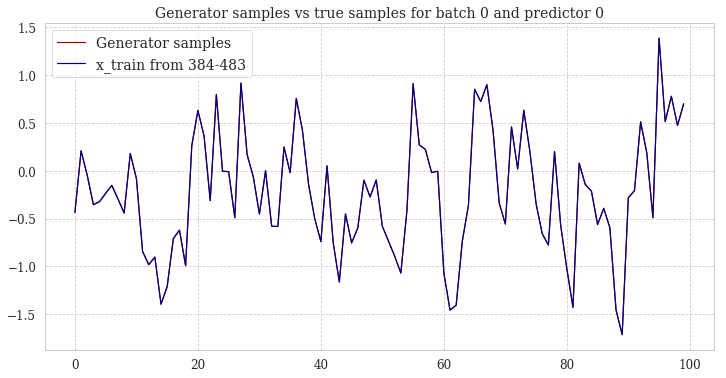

Targets equal? -1.1577 == -1.1577: True


In [16]:
batch_size, lookback, delay = 128, 100, 0
gen = generator(x_train, y_train, batch_size=batch_size, lookback=lookback, delay=delay)
samples, targets = next(gen)

batch = 0
increment = 3
for inc in range(increment):
    samples, targets = next(gen)

print(samples.shape, targets.shape)
predictor = 0
start_samples = batch + increment*batch_size
end_samples = batch + lookback + increment*batch_size
idxs = range(start_samples,end_samples)

gen_samples = samples[batch,:,predictor]
true_samples = x_train[idxs,predictor]

# plot should show that gen_samples == true_samples
plt.figure()
plt.plot(gen_samples, c="darkred", 
         label="Generator samples")
plt.plot(true_samples, c="darkblue",
         label="x_train from {0}-{1}".format(idxs[0],idxs[-1]))
plt.title("Generator samples vs true samples for batch {0} and predictor {1}".format(batch,predictor))
plt.legend(frameon=True)
plt.show()

feature = 0
gen_targets = targets[batch,feature]
true_targets = get_true_targets(true_data=y_train, batch_size=batch_size, delay=delay,
                                 lookback=lookback, increment=increment, batch=batch)[0,feature]
print("Targets equal? {0} == {1}: {2}".format(round(gen_targets,4), round(true_targets,4), np.all(gen_targets==true_targets)))

In [17]:
def test_generator(generator, x_data, y_data, batch_size=128, lookback=100, delay=0):
    gen = generator(x_data, y_data, lookback=lookback, delay=delay)
    gen_steps = choose_generator_steps(x_data,lookback,batch_size)
    
    for increment in range(gen_steps):
        samples, targets = next(gen)
        
        for batch in range(batch_size): 
            
            # *-----------------------------*
            # testing the samples/predictors
            # *-----------------------------*
            start_samples = batch + increment*batch_size
            end_samples = batch + lookback + increment*batch_size
            idxs=range(start_samples,end_samples)
            
            # samples[0,:,0] should equal data[start:end,0]
            for predictor in range(x_data.shape[-1]):
                assert np.all(samples[batch,:,predictor] == x_data[idxs,predictor])
            
            
            # *---------------------------*
            # testing the targets/features
            # *---------------------------*

            # targets[0,0] should equal data[start:end,0]
            for feature in range(y_data.shape[-1]):
                gen_targets = targets[batch,feature]
                true_targets = get_true_targets(true_data=y_data, batch_size=batch_size, delay=delay,
                                                lookback=lookback, increment=increment, batch=batch)[0,feature]
                assert np.all(gen_targets == true_targets)

In [18]:
test_generator(generator, x_train, y_train, batch_size=128, lookback=100, delay=0)

## 4. Model implementation
---

In [19]:
def plot_history(history, savepath=None):
    """
    Plots the training and validation loss history of the model in the training phase. 
    """
    epochs = history.epoch

    train_mae = history.history['loss']
    val_mae = history.history['val_loss']

    plt.figure()
    plt.plot(epochs, train_mae, marker='o', markersize='3.0', label=r'Training loss', color="darkred")
    plt.plot(epochs, val_mae, marker='o', markersize='3.0', label=r'Validation loss', color="darkblue")  
    plt.xlabel(r'Epoch')
    plt.ylabel(r'MAE')
    plt.legend(frameon=True)
    if savepath is not None: 
        plt.savefig(savepath)
    plt.show()

In [20]:
def build_model(input_layer, num_output_signals):  
    layer_1 = layers.GRU(128,
                         dropout = 0.2,
                         recurrent_dropout = 0.2,
                         kernel_initializer = 'glorot_normal')(input_layer)
    
    init = RandomUniform(minval=-0.05, maxval=0.05)
    output_layer = layers.Dense(num_output_signals, kernel_initializer=init)(layer_1)
    
    model = Model(input_layer, output_layer) 
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, 18)          0         
_________________________________________________________________
gru_1 (GRU)                  (None, 128)               56448     
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 56,835
Trainable params: 56,835
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
45/45 [==============================] - 7s 150ms/step - loss: 0.6017 - val_loss: 0.6529
Epoch 2/10
45/45 [==============================] - 7s 147ms/step - loss: 0.5425 - val_loss: 0.6175
Epoch 3/10
45/45 [==============================] - 7s 147ms/step - loss: 0.5353 - val_loss: 0.6209
Epoch 4/10
45/45 [==============================] - 7s 147ms/step - loss: 0.5273 - val_loss: 0.6249
Ep

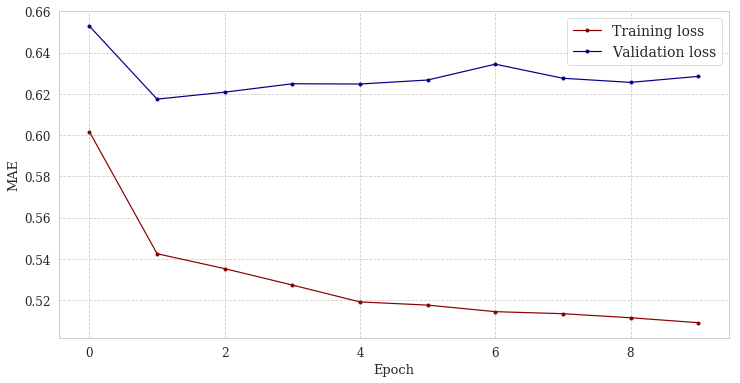

In [21]:
# Defining variables 
batch_size=128
lookback=200
epochs=10

# Defining generators and generator steps
train_gen = generator(x_train, y_train, lookback=lookback, batch_size=batch_size)
valid_gen = generator(x_valid, y_valid, lookback=lookback, batch_size=batch_size)
train_steps = choose_generator_steps(x_train, lookback=lookback, batch_size=batch_size)
valid_steps = choose_generator_steps(x_valid, lookback=lookback, batch_size=batch_size)

# Train the model
K.clear_session()
input_layer = Input(shape=(None,x_train.shape[-1]))
model = build_model(input_layer, y_train.shape[-1])
model.compile(loss='MAE', optimizer='ADAM')
model.summary()

history = model.fit_generator(generator=train_gen,
                              epochs=epochs,
                              steps_per_epoch=train_steps,
                              validation_data=valid_gen,
                              validation_steps=valid_steps)

plot_history(history)

## 5. Results

In [39]:
print((len(x_valid) - lookback) // batch_size)

14

In [42]:
valid_gen = generator(x_valid, y_valid, lookback=lookback, batch_size=batch_size)
valid_steps = (len(x_valid) - lookback) // batch_size
model.predict_generator(valid_gen, valid_steps).shape

(1792, 3)

In [41]:
get_true_targets(y_valid, batch_size, lookback)
def get_true_targets(true_data, batch_size, lookback, increment=0, batch=None, delay=0):

(1792, 3)

In [32]:
model.evaluate_generator(valid_gen, valid_steps)

0.6285128210272107

In [22]:
def make_prediction(model, x_data, y_data):
    gen = generator(x_data, y_data, lookback=lookback, batch_size=batch_size, delay=delay)
    gen_samples, gen_targets = next(gen)
    
    # make predictions
    preds = model.predict_on_batch(gen_samples)
    true = gen_targets
    
    return true, preds

def plot_prediction(model, x_data, y_data, plot_from, plot_length=None):
    plot_to = plot_from + plot_length if plot_length is not None else len(x_data)
    
    true, preds = make_prediction(model, x_data, y_data)
    
    for feature in range(y_data.shape[-1]):
        plt.figure()
        plt.title(feature_tags[feature])
        plt.plot(true[plot_from:plot_to,feature], c="darkred", label="true")
        plt.plot(preds[plot_from:plot_to,feature], c="darkblue", label="predictions")
        plt.legend(frameon=True)
        plt.show()
        
def evaluate_model(model, x_data, y_data):
    true, preds = make_prediction(model, x_data, y_data)
    return MAE(true, preds, vector=True)
    

IndexError: index 1999 is out of bounds for axis 0 with size 1999

In [31]:
gen = generator(x_valid, y_valid, lookback=lookback, batch_size=len(y_valid))
true, preds = make_prediction(model, x_valid, y_valid)

MAE(true,preds, vector=True)

200 128 0


array([0.74739078, 0.68727641, 0.72904941])

(1999, 18)

In [24]:
t,s=next(gen)
print(t.shape, s.shape)

(1798, 200, 18) (1798, 3)


200 128 0
MAE = [0.59705609]
200 128 0


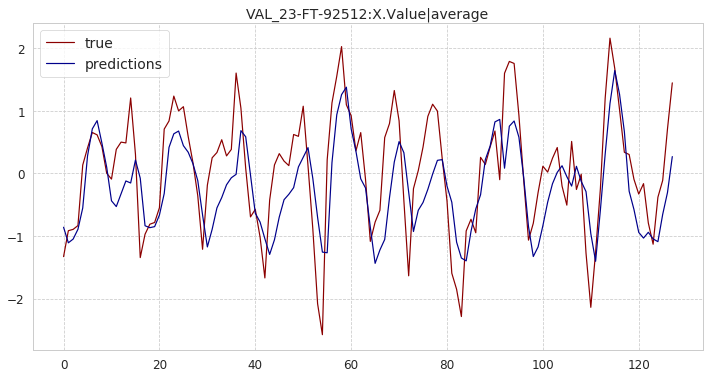

In [73]:
print("MAE = {0}".format(evaluate_model(model, x_valid, y_valid)))
plot_prediction(model, x_valid, y_valid, 0, 128)